## Creating graphs from molecules

In [4]:
from rdkit.Chem.rdmolfiles import MolFromMol2File
import os
import pandas as pd
from spektral.utils import nx_to_adj
from rdkit import Chem
import networkx as nx
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
train = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/train_graphs',
                    index_col = 0)
train_type_one = train.query("type == '1JHC'") #using only one category from the train set

train_type_one = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/train_type_one.csv',
                             index_col = [0])

In [ ]:
molecule_names_type_one = train_type_one['molecule_name'].unique()

### Converting .mol2 files to RDKit molecules

In [ ]:
def mol_2_files():
    files = []
    for file in os.listdir('/home/dionizije/Desktop/Code/Predicting molecular properties/mol'):
        if file.endswith('.mol2'):
            files.append(file)
    molecules = []
    for molecule in files:
        molecule_name = os.path.splitext(molecule)[0] #removes extensionmolecules = mol_2_files()
        if molecule_name in molecule_names_type_one:
            try: #try statement, because there is/could be a .mol2 file which is not a molecule and stops execution
                mol2_object = MolFromMol2File(molecule,
                                              sanitize = False)
                molecule_name = molecule.rsplit(".", 1)[0] #gets rid of the extension
                mol2_object.SetProp('_Name', '{}'.format(molecule_name))
                molecules.append(mol2_object)
            except:
                pass
    print('Molecules converted to RDkit molecules')
    return molecules

molecules = mol_2_files()

### Creating networkx graphs with simple attributes from the training set and RDKit molecules

In [1]:
def make_graphs(molecule):
    """ makes networkx graphs from training set and structures(rdkit molecules) """
    molecule_name = molecule.GetProp("_Name")
    molecule_data_from_train = train_type_one.query("molecule_name == '{}'".format(molecule_name))
    
    G = nx.Graph(name = molecule_name)

    for atom in molecule.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num = atom.GetAtomicNum(),
                   atom_symbol = atom.GetSymbol())
    for bond in molecule.GetBonds():
        bond_atom_0 = bond.GetBeginAtomIdx()
        bond_atom_1 = bond.GetEndAtomIdx()
        G.add_edge(bond.GetBeginAtomIdx(),
                       bond.GetEndAtomIdx(),
                       bond_type = bond.GetBondType())
        if bond_atom_0 in molecule_data_from_train['atom_index_0'].values and bond_atom_1 in molecule_data_from_train['atom_index_1'].values:
            atoms_data = molecule_data_from_train.loc[(molecule_data_from_train['atom_index_0'] == bond_atom_0) \
                                                        & (molecule_data_from_train['atom_index_1'] == bond_atom_1)]
        
        elif bond_atom_1 in molecule_data_from_train['atom_index_0'].values and bond_atom_0 in molecule_data_from_train['atom_index_1'].values:
            atoms_data = molecule_data_from_train.loc[(molecule_data_from_train['atom_index_0'] == bond_atom_1) \
                                                            & (molecule_data_from_train['atom_index_1'] == bond_atom_0)]
        
        else:
            """set to an arbitrary (if/elif) statement from code above to return empty rows and IndexError"""
            atoms_data = molecule_data_from_train.loc[(molecule_data_from_train['atom_index_0'] == bond_atom_1) \
                                                            & (molecule_data_from_train['atom_index_1'] == bond_atom_0)]
        try: 
            distance = atoms_data['dist_coupling_atoms'].values[0]
            scalar_coupling_constant = atoms_data['scalar_coupling_constant'].values[0]
            G[bond_atom_0][bond_atom_1]['dist_coupling_atoms'] = distance
            G[bond_atom_0][bond_atom_1]['scalar_coupling_constant'] = scalar_coupling_constant
            #color code the coupling edges to red
            G[bond_atom_0][bond_atom_1]['color'] = 'r'
            
        except IndexError:
            """ if atoms data in try statement has empty rows --> indexing the values returns IndexError"""
            #sets non scalar coupling type one bonds to color blue
            G[bond_atom_0][bond_atom_1]['color'] = 'b'          
            
    return G

molecule_graphs = []
for molecule in tqdm(molecules):
    molecular_graph = make_graphs(molecule)
    molecule_graphs.append(molecular_graph)

#### Reading graphs from disk

In [10]:
molecule_graphs = []
path = '/home/dionizije/Desktop/Code/Predicting molecular properties/Graph CNN/Type one graphs/'
for file in tqdm(os.listdir(path)):
    graphs = nx.read_gpickle(path + file)
    molecule_graphs.append(graphs)

100%|██████████| 84747/84747 [00:53<00:00, 1583.37it/s]


Drawing a graph to check values

In [11]:
G = molecule_graphs[0]

In [12]:
G

In [14]:
atom_symbols = nx.get_node_attributes(G, 'atom_symbol')
atom_symbols

{0: 'C',
 1: 'C',
 2: 'C',
 3: 'C',
 4: 'C',
 5: 'C',
 6: 'C',
 7: 'O',
 8: 'C',
 9: 'H',
 10: 'H',
 11: 'H',
 12: 'H',
 13: 'H',
 14: 'H',
 15: 'H',
 16: 'H',
 17: 'H',
 18: 'H',
 19: 'H',
 20: 'H',
 21: 'H',
 22: 'H'}

In [16]:
scalar_const = nx.get_edge_attributes(G, 'scalar_coupling_constant')
scalar_const

{(0, 9): 84.4251,
 (0, 10): 85.5588,
 (0, 11): 85.0537,
 (2, 12): 112.83,
 (4, 14): 80.3934,
 (4, 13): 80.7328,
 (4, 15): 87.0661,
 (5, 16): 81.1439,
 (5, 17): 81.1387,
 (5, 18): 82.3481,
 (6, 20): 91.7227,
 (6, 19): 83.1955,
 (8, 21): 91.1123,
 (8, 22): 88.359}

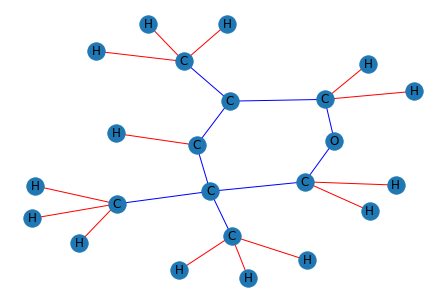

In [19]:
def draw_graph(graph):
    pos = nx.kamada_kawai_layout(graph)
    atom_symbols = nx.get_node_attributes(graph, 'atom_symbol')
    scalar_const = nx.get_edge_attributes(graph, 'scalar_const')
    edges = graph.edges()
    colors = [graph[u][v]['color'] for u, v in edges]
    nx.draw(graph, pos, labels = atom_symbols,edges = edges, edge_color = colors, width = 1)
    
draw_graph(molecule_graphs[0])